# Metadata

* Title: **Final Project Report**
* Class: DS 5100
* Date: April 29th, 2023
* Student Name: Hallie Parten
* Student Net ID: zsk4gm
* This URL: https://github.com/hparten/final_drop/blob/main/FinalProjectSubmission_Parten.ipynb
* GitHub Repo URL: https://github.com/hparten/final_drop

# The Monte Carlo Module

In [1]:
import numpy as np
import pandas as pd
import numbers

class Die:
    '''A die has N sides, or faces, and W weights, and can be rolled to select a face.
    W defaults to 1.0 for each face but can be changed after the object is created.
    The die has one behavior, which is to be rolled one or more times.
    '''
    
    weight = 1.0
    
    def __init__(self, faces): 
        '''Takes an array of faces as an argument. The array's data type (dtype) may be strings or numbers.
        '''
        self.faces = faces
        self._die_ = pd.DataFrame({
            'faces': self.faces,
            'weights': pd.Series([self.weight for x in range(len(self.faces))])
        })
        
    def change_weight(self, face, new_weight):
        '''A method to change the weight of a single side.
        
        Parameters: 
            face (string, number): the face value to be changed
            new_weight (float): the new weight 
        '''
        if face in self._die_.faces.values: 
            if (isinstance(new_weight, numbers.Number)==True) or (new_weight.isdigit()==True): 
                self._die_.loc[self._die_['faces'] == face, 'weights'] = float(new_weight)
            else: 
                raise ValueError("Your new weight must be a number!")
        else: 
            raise ValueError("That face is not on your die!")
            
        
            
            
    def roll_die(self, n_rolls=1):
        '''A method to roll the die one or more times.
        
        Parameters: 
            n_rolls(int): how many times the die is to be rolled; defaults to 1
            
        Returns: 
            a list of roll outcomes
        '''
        results = []
        for i in range(n_rolls):
            result = self._die_.faces.sample(weights=self._die_.weights).values[0]
            results.append(result)
        return pd.Series(results).to_list()
    
    def show_latest_die(self):
        '''A method to show the user the die's current set of faces and weights in a dataframe
        '''
        return self._die_
       

class Game:
    '''A game consists of rolling of one or more dice of the same kind one or more times.
    Each game is initialized with one or more of similarly defined (same # of sides and associated faces) dice (Die objects).
    The class has a behavior to play a game, i.e. to rolls all of the dice a given number of times.
    The class keeps the results of its most recent play.
    '''
    
    def __init__(self, dice):
        '''Takes a list of already instantiated similar Die objects.
        '''
        self.dice = dice
        
    def play_game(self, n_rolls):
        '''A method to play the game
        
        Parameters:
            n_rolls(int): how many ties the dice should be rolled
        '''
        game_result = []
        for i in self.dice:
            dice_result = pd.Series(i.roll_die(n_rolls))
            game_result.append(dice_result)
        self._game_result_df_ = pd.DataFrame(data=game_result).T
        self._game_result_df_.index.name = 'Roll Number'
        self._game_result_df_.columns.name = 'Die Number'
        
        
    def show_results(self, form='W'):
        '''A method to show the user the results of the most recent play.
        
        Parameters: 
            form('N' or 'W'): parameter to return the dataframe in narrow or wide form (defaults to 'W')
            
        Returns: 
            dataframe of results in either wide form (with index for roll number, column for each die number and face rolled)
            or narrow form (with a two column index with the roll number and die number, and a column for face rolled).
        '''
        if form=='W':
            return self._game_result_df_
        if form=='N':
            narrow_result = self._game_result_df_.stack().to_frame()
            narrow_result.rename(columns={0:'Face'}, inplace=True)
            return narrow_result
        else: 
            raise ValueError('You must specifiy you form as "W" for wide and "N" for narrow')
    
class Analyzer: 
    '''An analyzer takes the results of a single game and computes various descriptive statistical properties about it. 
    These properties results are available as attributes of an Analyzer object.
    
    Attributes (and associated methods) include:
        A face counts per roll, i.e. the number of times a given face appeared in each roll. 
            For example, if a roll of five dice has all sixes, then the counts for this roll would be 6 for the face value '6' and 0 for the other faces.
        A jackpot count, i.e. how many times a roll resulted in all faces being the same, e.g. all one for a six-sided die.
        A combo count, i.e. how many combination types of faces were rolled and their counts.'''
    
    jackpot_count = 0
    combo_count = 0
    face_counts_results = []
    jackpot_results = []
    combo_results = []
    
    def __init__(self, game):
        '''Takes a game object as its input parameter. At initialization time, it also infers the data type of the die faces used as an attribute.
        '''
        self.game = game 
        self.dtype_dice = [] 
        for i in self.game.dice: 
            dtype = type(i.faces[0])
            self.dtype_dice.append(dtype)
            
    def jackpot(self):
        '''A jackpot method to compute how many times the game resulted in all faces being identical.
        
        Returns: 
            jackpot_count: returns an integer for the number times to the user (also stored as a public attribute)
            jackpot_results: stores the results as a dataframe of jackpot results in a public attribute.
        '''
        self.jackpot_results = self.game.show_results().copy()
        self.jackpot_results['jackpot'] = self.jackpot_results.eq(self.jackpot_results.iloc[:, 0], axis=0).all(1).astype(int)
        self.jackpot_results = self.jackpot_results.loc[self.jackpot_results['jackpot'] == 1]
        self.jackpot_count = sum(self.jackpot_results['jackpot'])
        return self.jackpot_count
    
    def combo(self):
        '''A combo method to compute the distinct combinations of faces rolled, along with their counts.
        
        Stores as a public attribute:
            combo_results: a dataframe with a multi-columned index of the combinations, sorted. 
            combo_count: an overall count of distinct combinations
        '''
        combo_copy = self.game.show_results().copy()
        self.combo_results = combo_copy.groupby(list(combo_copy.columns)).size().to_frame('counts').sort_values('counts', ascending=False)
        self.combo_count = len(self.combo_results)
    
    def face_counts_per_roll(self):
        '''A method to compute how many times a given face is rolled in each event. 
        
        Stores as a public attribute: 
            face_counts_per_roll: a dataframe with an index of the roll numer and face values as columns'''
        face_copy = self.game.show_results().copy()
        face_values = []
        for i in range(len(face_copy)):
            face_count = face_copy.iloc[i].value_counts()
            face_values.append(face_count)
        self.face_counts_results = pd.DataFrame(face_values).fillna(0).astype(int)
        self.face_counts_results.index.name = 'Roll Number'
        self.face_counts_results.columns.name = 'Faces'  

# Test Module

In [2]:
#from montecarlo.montecarlo import Die, Game, Analyzer
import unittest

class DieTestSuite(unittest.TestCase): 

    def test_1_init_die(self): 
        '''checks that all the weights of the initialized die are 1.0''' 
        test_die = Die(['a','b','c','d'])
        Expected = [1.0, 1.0, 1.0, 1.0]
        Actual = list(test_die._die_.weights)
        self.assertEqual(Expected, Actual)    
    
    def test_2_change_weight(self): 
        '''checks that the exception is raised when an incorrect face is passed as an argument''' 
        test_die = Die(['a','b','c','d'])
        correct_weight = 2.5
        incorrect_face = 1
        self.assertRaises(ValueError, test_die.change_weight, incorrect_face, correct_weight)
        
    def test_3_change_weight(self): 
        '''checks that the exception is raised when an incorrect type of weight is passed'''
        test_die = Die(['a','b','c','d'])
        correct_face = 'a'
        incorrect_weight = 'b'
        self.assertRaises(ValueError, test_die.change_weight, correct_face, incorrect_weight)
        
    def test_4_change_weight(self): 
        '''checks that the numeric character is converted to a float and the weight is changed.''' 
        test_die = Die(['a','b','c','d'])
        test_die.change_weight('a', '2')
        Expected = 2
        Actual = test_die.show_latest_die().iloc[0]['weights']
        self.assertEqual(Expected, Actual)
        
    def test_5_change_weight(self):
        '''tests if weight for corresponding face is changed'''
        test_die = Die(['a','b','c','d'])
        test_die.change_weight('a', 2.5)
        Expected = 2.5
        Actual = test_die.show_latest_die().iloc[0]['weights']
        self.assertEqual(Expected, Actual)
    
    def test_6_roll_die(self): 
        '''tests if the correct number of rolls is outputted'''
        test_die = Die(['a','b','c','d'])
        test_die.roll_die(5)
        Expected = 5
        Actual = len(test_die.roll_die(5))
        self.assertEqual(Expected, Actual)
        
    def test_7_show_latest_die(self):
        '''tests if the size of the die dataframe is expected'''
        test_die = Die(['a','b','c','d'])
        Expected = (4,2)
        Actual = test_die.show_latest_die().shape
        self.assertEqual(Expected, Actual)
        
class GameTestSuite(unittest.TestCase):
    

    def test_1_play_game(self):
        '''tests that the size of the wide results dataframe is expected for n_rolls'''
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        Expected = (20, 2)
        Actual = test_game._game_result_df_.shape 
        self.assertEqual(Expected, Actual)
        
    def test_2_show_results_w(self): 
        '''tests that the size of the wide results data frame matches the expected size for n_rolls'''
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        Expected = (20, 2)
        Actual = test_game.show_results().shape
        self.assertEqual(Expected, Actual)
        
        
    def test_3_show_results_n(self): 
        '''tests that the size fo the narrow results dataframe is expected for n_rolls'''
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        Expected = (40, 1)
        Actual = test_game.show_results('N').shape
        self.assertEqual(Expected, Actual)
        
class GameAnalyzerSuite(unittest.TestCase):
        
    def test_1_jackpot(self):
        '''tests that size of the jackpot dataframe matches the jackpot count''' 
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        test_analyzer = Analyzer(test_game)
        test_analyzer.jackpot()
        Expected = (test_analyzer.jackpot_count, 3)
        Actual = test_analyzer.jackpot_results.shape
        self.assertEqual(Expected, Actual)
        
    def test_2_combo(self):
        '''tests that the size of the combo dataframe matches the combo count'''
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        test_analyzer = Analyzer(test_game)
        test_analyzer.combo()
        Expected = (test_analyzer.combo_count, 1)
        Actual = test_analyzer.combo_results.shape
        self.assertEqual(Expected, Actual)
        
    def test_3_face_counts_per_roll(self):
        '''tests that size of the face counts data frame is expected for n_rolls'''
        test_die1 = Die(['a','b','c','d'])
        test_die2 = Die(['a','b','c','d'])
        test_die2.change_weight('b', 2.0)
        test_game = Game([test_die1, test_die2])
        test_game.play_game(20)
        test_analyzer = Analyzer(test_game)
        test_analyzer.face_counts_per_roll()
        Expected = (20, 4)
        Actual = test_analyzer.face_counts_results.shape
        self.assertEqual(Expected, Actual)

        
#if __name__ == '__main__':    
#   unittest.main()    

# Test Results

.............
----------------------------------------------------------------------
Ran 13 tests in 0.643s

OK

# Scenarios

Code blocks with your scenarios and their outputs. 

These should have appropriate import statements even though the code is now in the same notebook as the classes it calls. 

## Scenario 1
**A 2-headed coin**

In [3]:
# import packages
import numpy as np
import pandas as pd
#from montecarlo.montecarlo import Die, Analyzer, Game
import matplotlib.pyplot as plt

1. Create a fair coin (with faces H and T) and one unfair coin, in which one of the faces has a weight of 5 and the others 1.

In [4]:
faces = ['H','T']
fair = Die(faces)
unfair = Die(faces)
unfair.change_weight('H', 5)

2. Play a game of 1000 flips with all fair dice.

In [5]:
fair_game = Game([fair, fair, fair])
fair_game.play_game(1000)

3. Play a game of 1000 flips with two unfair dice and one fair die.

In [6]:
unfair2 = Die(faces)
unfair2.change_weight('T', 20)
unfair_game = Game([fair, unfair, unfair])
unfair_game.play_game(1000)

4. For each game, use an Analyzer object to determine the
relative frequency of jackpots – getting either all Hs or all Ts.

In [7]:
fair_analyzer = Analyzer(fair_game)
unfair_analyzer = Analyzer(unfair_game)
fair_analyzer.jackpot()
unfair_analyzer.jackpot()
print('Fair Jackpot Count:', fair_analyzer.jackpot_count)
print('Unfair Jackpot Count:', unfair_analyzer.jackpot_count)

Fair Jackpot Count: 257
Unfair Jackpot Count: 361


5. Compute relative frequency as the number of jackpots over the
total number of rolls.

In [8]:
fair_jackpot_pct = fair_analyzer.jackpot_count/1000
unfair_jackpot_pct = unfair_analyzer.jackpot_count/1000
print('Fair Jackpot Percent:', fair_jackpot_pct)
print('Unfair Jackpot Percent:', unfair_jackpot_pct)

Fair Jackpot Percent: 0.257
Unfair Jackpot Percent: 0.361


6. Show your results, comparing the two relative frequencies, in a
simple bar chart.

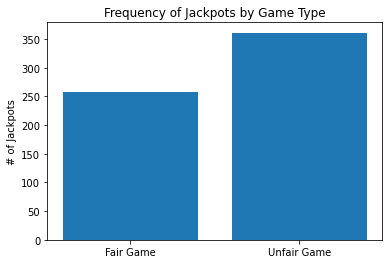

In [9]:
plt.bar(['Fair Game', 'Unfair Game'],[fair_analyzer.jackpot_count, unfair_analyzer.jackpot_count]);
plt.ylabel('# of Jackpots');
plt.title('Frequency of Jackpots by Game Type');

## Scenario 2
**A 6-sided die** 

1. Create a fair die and two unfair dice, all of six sides with the faces 1 through 6. One unfair die (Type 1) will weight 6 five times more than the others (i.e. it has weight of 5 and the others a weight of 1 each). The other unfair die (Type 2) will weight 1 five times more than the others.

In [10]:
faces2 = [1,2,3,4,5,6]
f_die = Die(faces2)
u_die1 = Die(faces2)
u_die1.change_weight(6, 5)
u_die2 = Die(faces2)
u_die2.change_weight(1, 5)

2. Play a game of 10000 rolls with 5 fair dice.

In [11]:
f_game = Game([f_die, f_die, f_die, f_die, f_die])
f_game.play_game(10000)

3. Play a game of 10000 rolls with 2 unfair dice of type 1, 1 unfair
die of type 2, and the rest fair dice.

In [12]:
u_game = Game([u_die1, u_die1, u_die2, f_die, f_die])
u_game.play_game(10000)

4. For each game, use an Analyzer object to determine the
relative frequency of jackpots and show your results,
comparing the two relative frequencies, in a simple bar chart.

In [13]:
f_analyzer = Analyzer(f_game)
u_analyzer = Analyzer(u_game)

f_analyzer.jackpot()
u_analyzer.jackpot()
f_analyzer.jackpot_results

Die Number,0,1,2,3,4,jackpot
Roll Number,,,,,,
76,6,6,6,6,6,1
462,1,1,1,1,1,1
757,5,5,5,5,5,1
934,3,3,3,3,3,1
1980,1,1,1,1,1,1
2406,2,2,2,2,2,1
3501,2,2,2,2,2,1
6501,3,3,3,3,3,1
8180,2,2,2,2,2,1


In [14]:
u_analyzer.jackpot_results

Die Number,0,1,2,3,4,jackpot
Roll Number,,,,,,
283,6,6,6,6,6,1
2897,1,1,1,1,1,1
3148,6,6,6,6,6,1
3180,6,6,6,6,6,1
3195,6,6,6,6,6,1
3543,6,6,6,6,6,1
4277,6,6,6,6,6,1
4551,4,4,4,4,4,1
4595,4,4,4,4,4,1


In [15]:
print('Fair Jackpot Count:', f_analyzer.jackpot_count)
print('Unfair Jackpot Count:', u_analyzer.jackpot_count)

Fair Jackpot Count: 9
Unfair Jackpot Count: 19


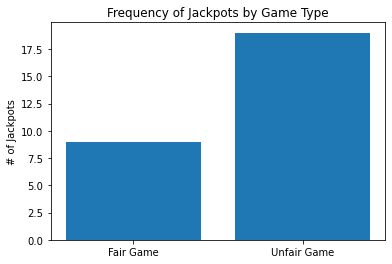

In [16]:
plt.bar(['Fair Game', 'Unfair Game'],[f_analyzer.jackpot_count, u_analyzer.jackpot_count]);
plt.ylabel('# of Jackpots');
plt.title('Frequency of Jackpots by Game Type');

5. Also compute 10 most frequent combinations of faces for each
game. Plot each of these as bar charts.

In [17]:
f_analyzer.combo()
u_analyzer.combo()
top10_fair_combos = f_analyzer.combo_results.head(10)
top10_fair_combos

counts
0 1 2 3 4        
6 3 5 6 5       7
4 1 1 5 6       7
6 3 4 2 2       7
  2 1 1 4       6
1 6 2 6 2       6
6 6 5 3 5       6
5 5 1 4 3       6
6 3 1 4 1       6
5 1 5 3 6       6
6 2 1 4 6       6

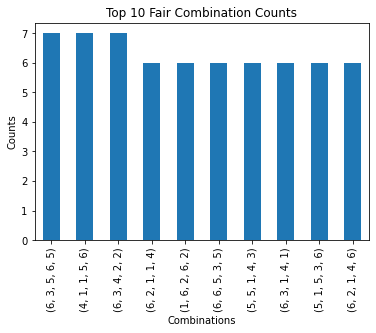

In [18]:
count_series = pd.Series(list(top10_fair_combos.counts.values))
fig = count_series.plot(kind='bar')
x_labels = list(top10_fair_combos.index.values)
fig.set_xticklabels(x_labels);
fig.set_xlabel('Combinations');
fig.set_ylabel('Counts');
fig.set_title('Top 10 Fair Combination Counts');

In [19]:
top10_unfair_combos = u_analyzer.combo_results.head(10)
top10_unfair_combos

counts
0 1 2 3 4        
6 6 1 1 4      45
      3 3      43
      5 4      43
        3      42
      4 3      42
      6 2      41
        5      41
      2 3      39
      3 4      38
      2 5      38

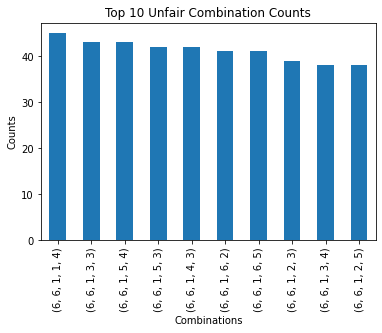

In [20]:
count_series2 = pd.Series(list(top10_unfair_combos.counts.values))
fig2 = count_series2.plot(kind='bar')
x_labels2 = list(top10_unfair_combos.index.values)
fig2.set_xticklabels(x_labels2);
fig2.set_xlabel('Combinations');
fig2.set_ylabel('Counts');
fig2.set_title('Top 10 Unfair Combination Counts');

## Scenario 3
**Letters of the Roman Alpha** 

1. Create a "die" of letters from a to z with weights based on their frequency of usage.

In [21]:
letters_freq_dict = {
    'A': 8.4966,
    'B': 2.0720,
    'C': 4.5388,
    'D': 3.3844,
    'E': 11.1607,
    'F': 1.8121,
    'G': 2.4705,
    'H': 3.0034,
    'I': 7.5448,
    'J': 0.1965,
    'K': 1.1016,
    'L': 5.4893,
    'M': 3.0129,
    'N': 6.6544,
    'O': 7.1635,
    'P': 3.1671,
    'Q': 0.1962,
    'R': 7.5809,
    'S': 5.7351,
    'T': 6.9509,
    'U': 3.6308,
    'V': 1.0074,
    'W': 1.2899,
    'X': 0.2902,
    'Y': 1.7779,
    'Z': 0.2722
}
letter_die = Die(list(letters_freq_dict.keys()))

for l, w in letters_freq_dict.items():
    letter_die.change_weight(l, w)
    
letter_die.show_latest_die()


,faces,weights
0,A,8.4966
1,B,2.0720
2,C,4.5388
3,D,3.3844
4,E,11.1607
5,F,1.8121
6,G,2.4705
7,H,3.0034
8,I,7.5448
9,J,0.1965


2. Play a game involving 5 of these dice with 1000 rolls.

In [22]:
letter_game = Game([letter_die, letter_die, letter_die, letter_die, letter_die])
letter_game.play_game(1000)

3. How many combos can you that look like actual English
words? NOTE: "combo" here just means resulting sequence,
not literally combination as opposed to permutation.

In [28]:
letter_analyzer = Analyzer(letter_game)
letter_analyzer.combo()
search_df = letter_analyzer.combo_results.reset_index().sort_values([0])
pd.set_option('max_rows', 1000)
#search_df ##this prints out a list of of all 1000 rows. I scanned them to see how many combinations were English words. I found 2

4. Based on your eye count, what is the relative frequency of
these words versus the rest?

In [24]:
freq = 2/1000
freq

0.002

# Directory Listing

A code block that executes the following bash command: 

```bash
!ls -lRF -o
```

In [25]:
!ls -lRF

.:
total 84
-rw-r--r-- 1 zsk4gm users 29159 Apr 29 20:23 FinalProjectSubmission_Parten.ipynb
-rw-r--r-- 1 zsk4gm users  1064 Apr 29 17:08 LICENSE
drwxr-sr-x 4 zsk4gm users  2048 Apr 29 19:57 montecarlo/
drwxr-sr-x 2 zsk4gm users  2048 Apr 29 20:12 montecarlo.egg-info/
-rw-r--r-- 1 zsk4gm users   112 Apr 29 17:27 montecarlo_test_results.txt
-rw-r--r-- 1 zsk4gm users  4053 Apr 29 19:08 README.md
-rw-r--r-- 1 zsk4gm users 10889 Apr 29 20:04 Scenarios.ipynb
-rw-r--r-- 1 zsk4gm users   407 Apr 29 18:32 setup.py
drwxr-sr-x 3 zsk4gm users  1536 Apr 29 19:15 tests/

./montecarlo:
total 20
-rw-r--r-- 1 zsk4gm users    0 Apr 29 19:57 __init__.py
-rw-r--r-- 1 zsk4gm users 7509 Apr 29 19:25 montecarlo.py
drwxr-sr-x 2 zsk4gm users 1024 Apr 29 19:56 __pycache__/

./montecarlo/__pycache__:
total 16
-rw-r--r-- 1 zsk4gm users  284 Apr 29 19:56 __init__.cpython-38.pyc
-rw-r--r-- 1 zsk4gm users 7836 Apr 29 19:41 montecarlo.cpython-38.pyc

./montecarlo.egg-info:
total 16
-rw-r--r-- 1 zsk4gm users   1 Apr 

# Installation Output Listing
    
A code block that executes the code to install your your package and outputs a successful installation.

In [26]:
!pip install -e .

Defaulting to user installation because normal site-packages is not writeable
Obtaining file:///sfs/qumulo/qhome/zsk4gm/Documents/MSDS/DS5100/DS5100-2023-01-zsk4gm/lessons/final_drop
  Preparing metadata (setup.py) ... done
  Attempting uninstall: montecarlo
    Found existing installation: montecarlo 0.1.0
    Uninstalling montecarlo-0.1.0:
      Successfully uninstalled montecarlo-0.1.0
  Running setup.py develop for montecarlo
